In [1]:
import random
import math
import time
import copy
import os
import pandas as pd
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
import transformers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_epochs = 10
batch_patience = 6
train_batch_size = 16
inference_batch_size = 128

stopping_stat = 'loss'

tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-large')
model = transformers.RobertaForSequenceClassification.from_pretrained('roberta-large')
model.classifier.out_proj = nn.Linear(in_features=1024, out_features=30, bias=True)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model = model.to(device)

train_optimizer = optim.AdamW(model.parameters(), lr=2e-5)
finetune_optimizer = train_optimizer
loss_fn = nn.CrossEntropyLoss(reduction='sum')

# train_steps = (6*34000)/32 ~ 6375.
scheduler = None # transformers.get_scheduler("linear", optimizer=train_optimizer, num_warmup_steps=100, num_training_steps=10000)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

In [3]:
DEBUG = False

In [4]:
class BookTitleDataset(Dataset):
    
    def __init__(self, df, test=False):
        self.df = df
        self.test = test
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        if self.test:
            return (idx, record['Title'])
        return (idx, record['Title'], record['Genre'])

In [5]:
def train_model(model, optimizer, lr_scheduler, iterator, batch_lim=256):
    
    model.train()
    loss, accuracy = 0, 0
    n_steps  = 0
    break_early = False
    
    for i in tqdm(range(batch_lim)):
        batch = next(iterator, None)
        if batch is None:
            break_early = True
            break
        idxs, titles, genres = batch
        tok_titles = tokenizer(list(titles), padding=True, truncation=True, return_tensors='pt')
        tok_titles = {k : v.to(device) for k,v in tok_titles.items()}        
        genres = genres.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(**tok_titles).logits
        _, preds = torch.max(outputs, 1)
        batch_loss = loss_fn(outputs, genres)
        
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.detach()
        accuracy += torch.count_nonzero(preds.detach() == genres)
        n_steps += 1

        if lr_scheduler:
            lr_scheduler.step()
                
    return {
        'loss': loss.cpu().item()/(train_batch_size*n_steps),
        'error': 1 - accuracy.cpu().item()/(train_batch_size*n_steps),
        'break_early': break_early
    }
    
def val_model(model, dataloader):
    model.eval()
    loss, accuracy = 0, 0
    n = len(dataloader.dataset)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            idxs, titles, genres = batch
            tok_titles = tokenizer(list(titles), padding=True, truncation=True, return_tensors='pt')
            tok_titles = {k : v.to(device) for k,v in tok_titles.items()}        
            genres = genres.to(device)

            outputs = model(**tok_titles).logits
            _, preds = torch.max(outputs, 1)
            batch_loss = loss_fn(outputs, genres)

            loss += batch_loss
            accuracy += torch.count_nonzero(preds == genres)
        
    return {
        'loss': loss.cpu().item()/n,
        'error': 1 - accuracy.cpu().item()/n
    }

def predict_model(model, dataloader):
    loss, accuracy = 0, 0
    n = len(dataloader.dataset)
    genres = torch.zeros(n, dtype=torch.long).to(device)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            idxs, titles = batch
            tok_titles = tokenizer(list(titles), padding=True, truncation=True, return_tensors='pt')
            tok_titles = {k : v.to(device) for k,v in tok_titles.items()}        

            outputs = model(**tok_titles).logits
            _, preds = torch.max(outputs, 1)
            genres[idxs] = preds
        
    return pd.DataFrame({'Genre': genres.cpu()}).rename_axis('Id')

def compute_total_norm():
    with torch.no_grad():
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
    return total_norm

def run(dataloaders, savepath='/kaggle/working'):
    
    train_stats, val_stats = [], []
    
    best_stat = 1e15
    patience_ctr = 0
    best_wts = None
    orig_wts = copy.deepcopy(model.state_dict())
    training_done = False
    
    print(f"Training Model")
    for i in range(1, n_epochs+1):
        print(f"\nEpoch {i}:")
        
        if training_done:
            break
        
        train_iterator = iter(dataloaders['train'])
        broke_early = False
        while not broke_early:
            train_stat = train_model(model, train_optimizer, scheduler, train_iterator)
            broke_early = train_stat['break_early']
            print("  Training:")
            for stat, value in train_stat.items():
                print(f"    {stat:6} = {value}")

            val_stat = val_model(model, dataloaders['val'])
            print("  Validation:")
            for stat, value in val_stat.items():
                print(f"    {stat:6} = {value}")

            total_norm = compute_total_norm()
            train_stat['norm'] = total_norm

            train_stats.append(train_stat)
            val_stats.append(val_stat)

            if (val_stat[stopping_stat] < best_stat):
                best_stat = val_stat[stopping_stat]
                best_wts = copy.deepcopy(model.state_dict())
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= batch_patience:
                    print(f"{stopping_stat} has not improved in {batch_patience} epochs. Stopping.")
                    training_done = True
                    break
    
    model.load_state_dict(best_wts)
    
    # finetuning - early stopping here as well?
    print(f"Finetuning Model")
    finetuning_done = False
    for i in range(1, n_epochs+1):
        print(f"Epoch {i}:")
        
        if finetuning_done:
            break
        
        finetune_iterator = iter(dataloaders['all'])
        broke_early = False
        while not broke_early:
            train_stat = train_model(model, train_optimizer, None, finetune_iterator)
            broke_early = train_stat['break_early']
            print("  Training:")
            for stat, value in train_stat.items():
                print(f"    {stat:6} = {value}")

            val_stat = val_model(model, dataloaders['val'])
            print("  Validation:")
            for stat, value in val_stat.items():
                print(f"    {stat:6} = {value}")

            total_norm = compute_total_norm()
            train_stat['norm'] = total_norm

            train_stats.append(train_stat)
            val_stats.append(val_stat)

            if (val_stat[stopping_stat] < best_stat):
                finetuning_done = True
                break

    torch.save(model, f'{savepath}/roberta.pt')
    
    return train_stats, val_stats

## Running

In [6]:
def process_df(df):
    df['Title'] = df['Title'].str.strip()
    df['Title'] = df['Title'].str.replace(r' [;,\.:] ', ' ', regex=True)
    df['Title'] = df['Title'].str.replace(r'^[;,\.:]', '', regex=True)
    df['Title'] = df['Title'].str.replace(r'[;,\.:]$', '', regex=True)
    df['Title'] = df['Title'].str.strip()
    return df

def load_train_df(x_path, y_path, debug_len=64):
    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path)
    df = pd.merge(process_df(X), y, left_on='Id', right_on='Id', how='left')
    df.set_index('Id', inplace=True)
    return df.iloc[:debug_len] if DEBUG else df

def load_df(df_path, debug_len=64):
    df = pd.read_csv(df_path)
    df = df.set_index('Id')
    return df.iloc[:debug_len] if DEBUG else df

In [7]:
dpath = '/kaggle/input/col774-2022'
train_df = load_train_df(f'{dpath}/train_x.csv', f'{dpath}/train_y.csv', debug_len=128)
val_df = load_train_df(f'{dpath}/non_comp_test_x.csv', f'{dpath}/non_comp_test_y.csv', debug_len=32)
# gen_df = load_df('/kaggle/input/book-title-generator-data/gen_df.csv')
test_df = process_df(load_df(f'{dpath}/comp_test_x.csv'))

all_df = train_df.append(val_df, ignore_index=True)

train_df, val_df = np.split(all_df.sample(frac=1), [(int)(0.95*len(all_df))])
                                  
# train_df = train_df.append(gen_df.iloc[:-6000], ignore_index=True)
# gen_df = gen_df.iloc[-6000:]

In [8]:
dataloaders = {
    'train': DataLoader(BookTitleDataset(train_df), batch_size=train_batch_size, shuffle=True, num_workers=2),
    'val'  : DataLoader(BookTitleDataset(val_df), batch_size=inference_batch_size, shuffle=False, num_workers=2),
    'all'  : DataLoader(BookTitleDataset(all_df), batch_size=train_batch_size, shuffle=True, num_workers=2),
    'test' : DataLoader(BookTitleDataset(test_df, test=True), batch_size=inference_batch_size, shuffle=False, num_workers=2)
}

In [9]:
train_stats, val_stats = run(dataloaders)

Training Model

Epoch 1:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.421844482421875
    error  = 0.96728515625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.3942228618421053
    error  = 0.9609022556390977


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.414133071899414
    error  = 0.962646484375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.405593329025689
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4162375926971436
    error  = 0.969970703125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.40548710643797
    error  = 0.9674185463659148


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4121501445770264
    error  = 0.970703125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4088154957706767
    error  = 0.9709273182957393


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.415156602859497
    error  = 0.968505859375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.407386141134085
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.415191888809204
    error  = 0.964599609375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4062152451441103
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.411360025405884
    error  = 0.963134765625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.408272389959273
    error  = 0.9644110275689223
loss has not improved in 6 epochs. Stopping.

Epoch 2:
Finetuning Model
Epoch 1:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.414476156234741
    error  = 0.97119140625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4055191690162907
    error  = 0.9654135338345865


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4105172157287598
    error  = 0.965576171875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.412430735040727
    error  = 0.9729323308270676


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4117326736450195
    error  = 0.96484375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4173593162593985
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.413945436477661
    error  = 0.96728515625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4082577048088973
    error  = 0.9674185463659148


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4110546112060547
    error  = 0.968017578125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4039750254542605
    error  = 0.962907268170426


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4088635444641113
    error  = 0.966552734375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4146516192825813
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.405303955078125
    error  = 0.964111328125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4085939947525064
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.411888599395752
    error  = 0.9677734375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.406515311716792
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4119255542755127
    error  = 0.96240234375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.405642034774436
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.409233334189967
    error  = 0.9697368421052631
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4058821369830827
    error  = 0.9659147869674185
Epoch 2:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4085683822631836
    error  = 0.968017578125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4098720923402257
    error  = 0.9724310776942355


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4064085483551025
    error  = 0.9658203125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4097294016290727
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.410243272781372
    error  = 0.964111328125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.409921287593985
    error  = 0.9634085213032582


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.409339427947998
    error  = 0.968017578125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4080117285401004
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.407644271850586
    error  = 0.9658203125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.412595942982456
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4079129695892334
    error  = 0.96044921875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.405346373746867
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4066805839538574
    error  = 0.9638671875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.409192659382832
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.407066583633423
    error  = 0.96240234375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4103997787437343
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.407054901123047
    error  = 0.96240234375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4191944705513784
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4052140085320723
    error  = 0.9608552631578947
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4237192101347116
    error  = 0.9644110275689223
Epoch 3:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.408032178878784
    error  = 0.962646484375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4272627369204263
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.409849166870117
    error  = 0.962646484375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.437480909304511
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4024460315704346
    error  = 0.964599609375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4280491267230575
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4064550399780273
    error  = 0.964599609375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.415495281171679
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4009077548980713
    error  = 0.961669921875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4598588757048874
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.40742564201355
    error  = 0.96337890625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4386498472744362
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4045801162719727
    error  = 0.960693359375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.431454613095238
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4039723873138428
    error  = 0.963623046875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.414799449796366
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.406660795211792
    error  = 0.958251953125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4367596236685465
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3962154990748354
    error  = 0.9618421052631579
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4416309328007517
    error  = 0.9659147869674185
Epoch 4:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4047482013702393
    error  = 0.960205078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4577794584116543
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4033920764923096
    error  = 0.96435546875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4276350054824563
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.407534599304199
    error  = 0.96875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.433296130952381
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4030468463897705
    error  = 0.962158203125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.459469719219925
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4004881381988525
    error  = 0.958984375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4797939673402256
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3992114067077637
    error  = 0.958251953125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4302663396773183
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.393209218978882
    error  = 0.954345703125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5253358004385964
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4019813537597656
    error  = 0.96240234375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4885580650845864
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4068074226379395
    error  = 0.964111328125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4828810307017544
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3955360814144737
    error  = 0.9588815789473684
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.509409999608396
    error  = 0.9769423558897243
Epoch 5:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.398254156112671
    error  = 0.962158203125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4608946683114037
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3971614837646484
    error  = 0.955810546875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.490520245927318
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.402754545211792
    error  = 0.960693359375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.445238584743108
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3991122245788574
    error  = 0.962158203125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4727367735745616
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.401811122894287
    error  = 0.962890625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4737196996397244
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.395143747329712
    error  = 0.958984375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.464222568139098
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.397120237350464
    error  = 0.960205078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.446512032033208
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.398785352706909
    error  = 0.9599609375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4556085036810775
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.397873640060425
    error  = 0.958251953125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.475435659461153
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3967972604851973
    error  = 0.9582236842105263
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5053062343358397
    error  = 0.9769423558897243
Epoch 6:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4000096321105957
    error  = 0.9619140625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.476960712327694
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3908190727233887
    error  = 0.95703125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4981548108552634
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3981306552886963
    error  = 0.96240234375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.49617109179198
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3977112770080566
    error  = 0.959228515625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4902882205513786
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.399484872817993
    error  = 0.955810546875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5273214775219297
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.4002323150634766
    error  = 0.963134765625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.49046444235589
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3955812454223633
    error  = 0.955078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4543056860902257
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.391860008239746
    error  = 0.965576171875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.621039414943609
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.385880470275879
    error  = 0.95068359375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5077084801848373
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3895925421463815
    error  = 0.9608552631578947
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.474211407424812
    error  = 0.9769423558897243
Epoch 7:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.399205446243286
    error  = 0.958251953125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.458456443843985
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3972277641296387
    error  = 0.95947265625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.448831062030075
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3919708728790283
    error  = 0.9541015625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.472375274122807
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.385498285293579
    error  = 0.952392578125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.490224095394737
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3917999267578125
    error  = 0.9580078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.49332070410401
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.389389753341675
    error  = 0.9638671875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5056772791353383
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3910632133483887
    error  = 0.961181640625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.468322417371554
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.39693021774292
    error  = 0.962646484375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4824049870770675
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.400172472000122
    error  = 0.9580078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4717851758302003
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3899497584292764
    error  = 0.9628289473684211
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.489349105184837
    error  = 0.9644110275689223
Epoch 8:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.396047353744507
    error  = 0.96142578125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4789796757518796
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3892223834991455
    error  = 0.958984375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.526840538847118
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3977749347686768
    error  = 0.95947265625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4882810052474937
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.392272710800171
    error  = 0.960693359375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.504092261904762
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.402054786682129
    error  = 0.961669921875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.469319049577068
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.401888608932495
    error  = 0.961181640625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.460752222352757
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3965678215026855
    error  = 0.964599609375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4712175947681705
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.395650625228882
    error  = 0.960205078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.479513236215539
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3857619762420654
    error  = 0.96142578125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5137599859022557
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.395420435855263
    error  = 0.9608552631578947
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.480280780075188
    error  = 0.9644110275689223
Epoch 9:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3972301483154297
    error  = 0.96484375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4696218084273185
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3951034545898438
    error  = 0.959716796875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.486682526629073
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3895814418792725
    error  = 0.9580078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5255876507675437
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.391299247741699
    error  = 0.961669921875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.499101758302005
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3926897048950195
    error  = 0.962890625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.476932076284461
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3937385082244873
    error  = 0.958251953125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5066381774749376
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3935999870300293
    error  = 0.96142578125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4954806449718046
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3980367183685303
    error  = 0.963623046875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4653601777882206
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.391270399093628
    error  = 0.960693359375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.491850231046366
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.385909231085526
    error  = 0.9578947368421052
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4879094709429825
    error  = 0.9664160401002506
Epoch 10:


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.394782543182373
    error  = 0.961669921875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.46722812891604
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3881759643554688
    error  = 0.957275390625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.495871514724311
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3865432739257812
    error  = 0.963134765625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.5050103285557643
    error  = 0.9729323308270676


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.389690637588501
    error  = 0.959716796875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.49529022752193
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3893752098083496
    error  = 0.959228515625
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.470728089755639
    error  = 0.9769423558897243


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.390502691268921
    error  = 0.960205078125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4991370026629074
    error  = 0.9664160401002506


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.393857002258301
    error  = 0.95751953125
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.4748374843358394
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3856334686279297
    error  = 0.9599609375
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.529156876566416
    error  = 0.9659147869674185


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3940417766571045
    error  = 0.959716796875
    break_early = False


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.480709096961153
    error  = 0.9644110275689223


  0%|          | 0/256 [00:00<?, ?it/s]

  Training:
    loss   = 3.3849814967105263
    error  = 0.9585526315789473
    break_early = True


  0%|          | 0/16 [00:00<?, ?it/s]

  Validation:
    loss   = 3.531770343828321
    error  = 0.9664160401002506


In [10]:
model.module.classifier.out_proj

Linear(in_features=1024, out_features=30, bias=True)

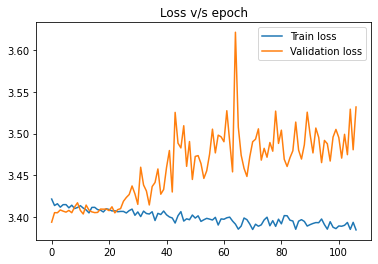

In [11]:
plt.plot([a['loss'] for a in train_stats], label='Train loss')
plt.plot([a['loss'] for a in val_stats], label='Validation loss')
plt.legend()
plt.title("Loss v/s epoch")
plt.show()

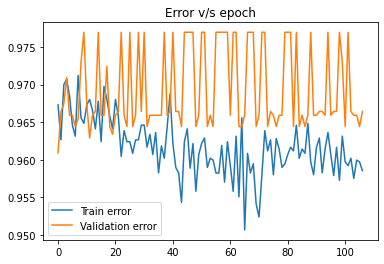

In [12]:
plt.plot([a['error'] for a in train_stats], label='Train error')
plt.plot([a['error'] for a in val_stats], label='Validation error')
plt.legend()
plt.title("Error v/s epoch")
plt.show()

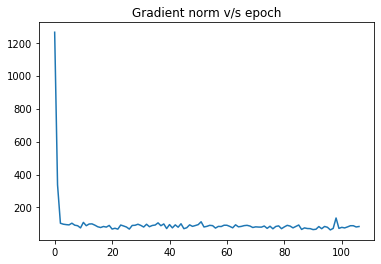

In [13]:
plt.plot([a['norm'] for a in train_stats], label='norm')
plt.title("Gradient norm v/s epoch")
plt.show()

In [14]:
preds = predict_model(model, dataloaders['test'])
preds.to_csv(f"/kaggle/working/submission.csv")

  0%|          | 0/90 [00:00<?, ?it/s]